In [1]:
import numpy as np
import scipy.signal as sg
import scipy.integrate as ig

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
path = '/home/lorenzo/phd/LQG/Experiments/SplitConvergence'

M = [5.0]#, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0]
#dxs = [0.01, 0.005, 0.0025]
dx = 0.005

In [3]:
# B = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/B.dat',     skiprows=sr, max_rows=mr)
# E = np.loadtxt(path + f'/m{ms[0]}_dx{dx}_xMax70.0/outputs/E.dat',     skiprows=sr, max_rows=mr)

In [4]:
sr = 0
mr = 8000

skipped = 10


main_peak = {}
second_peak = {}
third_peak = {}

for m in M:

    p1 = []
    p2 = []
    p3 = []

    x = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/xs.dat')
    r = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/rho.dat',   skiprows=sr, max_rows=mr)
    t = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/times.dat', skiprows=sr, max_rows=mr)

    for idx in range(len(r)):
        idx_MAX = sg.find_peaks(r[idx, skipped:], height=[1e-2], distance=2)[0][::-1]

        if len(idx_MAX) == 1:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], np.NaN, np.NaN])
            p3.append([t[idx, 0], np.NaN, np.NaN])
        elif len(idx_MAX)  == 2:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
            p3.append([t[idx, 0], np.NaN, np.NaN])
        elif len(idx_MAX)  == 3:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
            p3.append([t[idx, 0], x[skipped+idx_MAX[2]], skipped+idx_MAX[2]])
        else:
            pass
            # print("too many peaks!")

    main_peak[m]   = np.array(p1)
    second_peak[m] = np.array(p2)
    third_peak[m]  = np.array(p3)

    third_peak[m][third_peak[m][:,0] < 220, 1:] = np.NaN

/tmp/ipykernel_5232/3405630115.py:18: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=8000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  r = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/rho.dat',   skiprows=sr, max_rows=mr)
/tmp/ipykernel_5232/3405630115.py:19: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=8000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you

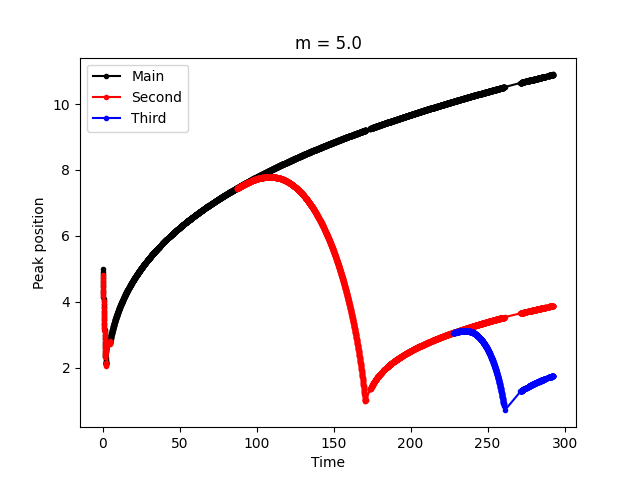

In [5]:
fig = plt.figure()

id = M[0]

plt.plot(main_peak[id][:,0], main_peak[id][:,1], '.-', color = 'k', label = 'Main')
plt.plot(second_peak[id][:,0], second_peak[id][:,1], '.-', color = 'r', label = 'Second')
plt.plot(third_peak[id][:,0], third_peak[id][:,1], '.-', color = 'b', label = 'Third')

plt.xlabel("Time")
plt.ylabel("Peak position")

plt.title(f'm = {id}')
plt.legend()

The fact that the position is piecewise constant tells me that the time step dt can be increased by a lot, since most of the timesteps are spent trying to resolve a movement much smaller then the grid. This would also speed up the simulations!

If such a small dt is needed for stability it is possible to reduce the number of time the output is saved, saving disk space.

In [6]:
first_index = []
peaks = []
time_pos = []

for id in M:
    for i in range(len(second_peak[id][:,1])):
        if not np.isnan(second_peak[id][i,1]):
            print(f'm = {id}; time = {second_peak[id][i,0]}, position = {second_peak[id][i,1]}, index = {i}')
            first_index.append(i)
            peaks.append(second_peak[id][i,1])
            time_pos.append(second_peak[id][i,0])
            break

m = 5.0; time = 0.10004999999999714, position = 4.8000005, index = 2


In [7]:
from scipy.optimize import curve_fit
# def lin(x, a, b):
#     return a*x + b
def quad(x, a, b, c):
    return a*x**2 + b*x + c
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

mask = np.array([True, True, True, True, True, True, False, True])
peak_pos = np.array(peaks)[mask]
ms = np.array(M)[mask]

G_pos = np.array(peaks)[~mask]
G_mas = np.array(M)[~mask]

# lopt, lcov = curve_fit(lin, ms, peak_pos)
qopt, qcov = curve_fit(quad, ms, peak_pos)
copt, ccov = curve_fit(cubic, ms, peak_pos)

mm = np.linspace(0, 1.1*ms[-1])

fig = plt.figure(figsize=(9,5))
frame1=fig.add_axes((.1,.3,.8,.6))

# plt.plot(mm, lin(mm, *lopt) , color = 'r', label = 'Linear Fit')
plt.plot(mm, quad(mm, *qopt), color = 'b', label = 'Quadratic Fit')
plt.plot(mm, cubic(mm, *copt), color = 'r', label = 'Cubic Fit')

plt.scatter(ms, peak_pos, color = 'k', marker='o', label = 'Used for fit')
plt.scatter(G_mas, G_pos, color = 'k', marker='+', label = 'Not used for fit')
plt.scatter([0.59], [3.05], color = 'k', marker='+')
# plt.plot([20, 40], [15.226,20.156], 'x', label = 'Quadratic Prediction')
# plt.plot([20, 40], [18.029, 35.237],'x', label = 'Cubic Prediction' )

plt.ylabel('Pos. of split')

plt.xlim(0, 1.1*ms[-1])

plt.xticks([])
plt.legend()

frame2=fig.add_axes((.1,.1,.8,.2))

plt.axhline(0, ls = '--', color = 'k', alpha = 0.5)
# plt.scatter(ms, lin(ms, *lopt) - peak_pos,  color = 'r')
plt.scatter(ms, quad(ms, *qopt) - peak_pos, color = 'b')
plt.scatter(ms, cubic(ms, *copt) - peak_pos, color = 'r')

plt.xlabel('Mass')
plt.ylabel('Residuals')

plt.xlim(0, 1.1*ms[-1])

# s_lcov = np.round(np.sqrt(np.diagonal(lcov)), 3)
s_qcov = np.round(np.sqrt(np.diagonal(qcov)), 3)
s_ccov = np.round(np.sqrt(np.diagonal(ccov)), 5)

# text_lin = f"Linear best fit parameters: ({np.round(lopt[0],3)} +- {s_lcov[0]}) x + ({np.round(lopt[1],3)} +- {s_lcov[1]})"
text_quad = f"Quadratic best fit parameters: ({np.round(qopt[0],3)} +- {s_qcov[0]}) x^2 + ({np.round(qopt[1],3)} +- {s_qcov[1]}) x + ({np.round(qopt[2],3)} +- {s_qcov[2]})"
text_cubic = f"Cubic best fit parameters: ({np.round(copt[0],5)} +- {s_ccov[0]}) x^3 + ({np.round(copt[1],3)} +- {s_ccov[1]}) x^2 + ({np.round(copt[2],3)} +- {s_ccov[2]}) x + ({np.round(copt[3],3)} +- {s_ccov[3]})"

# print(text_lin)
print(text_quad)
print(text_cubic)
print()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 8

In [ ]:
np.savetxt('./fits/cubic_opt.dat', copt)
np.savetxt('./fits/cubic_cov.dat', ccov)
np.savetxt('./fits/quadr_opt.dat', qopt)
np.savetxt('./fits/quadr_cov.dat', qcov)

## Post

In [ ]:
import numpy as np
import scipy.signal as sg

import matplotlib.pyplot as plt
%matplotlib widget

def quad(x, a, b, c):
    return a*x**2 + b*x + c
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

copt = np.loadtxt('./fits/cubic_opt.dat')
ccov = np.loadtxt('./fits/cubic_cov.dat')
qopt = np.loadtxt('./fits/quadr_opt.dat')
qcov = np.loadtxt('./fits/quadr_cov.dat')

In [ ]:
print(f'Quadratic prediction for m={0.5911875} : {quad(0.5911875, *qopt)}')
print(f'Cubic prediction for m={0.5911875} : {cubic(0.5911875, *copt)}')

Quadratic prediction for m=0.5911875 : 4.399306176302657
Cubic prediction for m=0.5911875 : 3.4251677829205893
